# Load gene sets and get score

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NCEM_RES_DIR = Path("/Users/louis.kuemmerle/Promotion/projects/G1/from_Maiia/230922_ncem_results")
RES_DIR = "/Users/louis.kuemmerle/Promotion/projects/G1/results/spapros_smk_res"
#DATA_DIR = "/Volumes/TOSHIBA_EXT/Promotion/data/G1/2022Fang_merfish"

In [3]:
df_eval = pd.read_csv(Path(RES_DIR, "evaluation_overview.csv"),index_col=0)
df_data = pd.read_csv(Path(RES_DIR, "data_parameters.csv"),index_col=0)
df_sele = pd.read_csv(Path(RES_DIR, "selection_overview.csv"),index_col=0).set_index("selection_name")

In [4]:
eval_experiment_to_batch = {
    "sn":"eval_batch6.1",
    "merfish":"eval_batch6.2.1",
    "merfish fine ct":"eval_batch6.2.2",
}

selection_experiment_to_batch = {
    "sn":"batch6.1",
    "merfish":"batch6.2.1",
    "merfish fine ct":"batch6.2.2",
}

experiment_to_eval_data_id = {
    exp:df_eval.loc[df_eval["eval_batch"] == batch,"eval_data_id"].unique()[0] for exp, batch in eval_experiment_to_batch.items()
}
experiment_to_eval_dataset = {
    exp:df_eval.loc[df_eval["eval_batch"] == batch,"eval_dataset"].unique()[0] for exp, batch in eval_experiment_to_batch.items()
}

## Generate plot df (no need to rerun, saved at the end)

#### Load metrics and infos of selections

In [5]:
df_sn = pd.read_csv(Path(RES_DIR, f"evaluation/{experiment_to_eval_dataset['sn']}_{experiment_to_eval_data_id['sn']}_summary.csv"), index_col=0)
df_sp = pd.read_csv(Path(RES_DIR, f"evaluation/{experiment_to_eval_dataset['merfish']}_{experiment_to_eval_data_id['merfish']}_summary.csv"), index_col=0)

In [6]:
for df in [df_sn, df_sp]:
    #df["method"] = df.index.to_series().apply(
    #    lambda x: x.split("_")[0])
    df["ct score"] = (
        df['forest_clfs accuracy'] + df['forest_clfs perct acc > 0.8']) / 2
    df["var score"] = (
        df['knn_overlap mean_overlap_AUC'] +
        df['cluster_similarity nmi_5_20'] +
        + df['cluster_similarity nmi_21_60']
    ) / 3
    df["score"] = (
        df["ct score"] + df["var score"]) / 2

df_sn = df_sn.rename(columns={col:f"(sn) {col}" for col in df_sn.columns})
df_sp = df_sp.rename(columns={col:f"(sp) {col}" for col in df_sp.columns})

In [7]:
# # get index overlap between sn and sp
# idx_overlap = df_sn.index.intersection(df_sp.index)

# Concatenate sn and sp on shared index
df = pd.concat([df_sn, df_sp], axis=1, join="inner")
df["method"] = df.index.to_series().apply(lambda x: x.split("_")[0])
df = df.loc[~df.isna().any(axis=1)]
df["n"] = df_sele.loc[df.index,"n"].values
df["modality"] = df_sele.loc[df.index,"dataset"].apply(lambda d: "sp" if ("merfish" in d) else "sn")


#### Add spatial variation stats

In [8]:
# Ordered by the 5 samples
stats_files = [
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep1.csv',
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep2.csv',
    'ncem_tested_parms_H18.06.006.MTG.3491.expand.rep3.csv',
    'ncem_tested_parms_H22.26.401.MTG.3491.expand.rep1.csv',
    'ncem_tested_parms_H22.26.401.MTG.3491.expand.rep2.csv',
]
pval_files = [
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep1.csv',
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep2.csv',
    'ncem_fdr_pval_H18.06.006.MTG.3491.expand.rep3.csv',
    'ncem_fdr_pval_H22.26.401.MTG.3491.expand.rep1.csv',
    'ncem_fdr_pval_H22.26.401.MTG.3491.expand.rep2.csv',
]


In [9]:
# Define gene set scores in different ways

# We have two matrices per sample: test statistics and p-values
# each matrix has genes as index and cell-cell interaction pairs as columns

# score: sum (over selected genes) of significant interactions per gene (argument: pval_th = 0.05 as default)

def gene_scores_nr_of_sign_interactions(pval_df, pval_th=0.05):
    """
    """
    df = (pval_df < pval_th)
    return (df.sum(axis=1) / df.sum().sum()).copy()    
    
def get_score(genes, df_gene_scores):
    """
    """
    return df_gene_scores.loc[genes].sum()


In [11]:
# Get score for each gene set:
print("Calc gene set scores")
columns = ["CCI_n_interactions"]
for b in range(len(stats_files)):
    columns += [f"CC_n_interactions_{b}"]
df_cci = pd.DataFrame(
    index=df.index, 
    columns=columns,
    dtype='float64'
)

pval_dfs = [pd.read_csv(NCEM_RES_DIR / pval_files[b], index_col=0) for b in range(len(stats_files))]
test_stat_dfs = [pd.read_csv(NCEM_RES_DIR / stats_files[b], index_col=0) for b in range(len(stats_files))]

dfs_score1 = [gene_scores_nr_of_sign_interactions(pval_df, pval_th=0.05) for pval_df in pval_dfs]

for i,selection in enumerate(df.index): 
    if (not (i % 100)) or (i == (len(df)-1)):
        print(i+1,"/",len(df))
    if Path(RES_DIR, "selection", selection+".csv").exists():
        tmp_df = pd.read_csv(Path(RES_DIR, "selection", selection+".csv"),index_col=0)
    else:
        continue
    genes = tmp_df.loc[tmp_df.iloc[:,0]].index.tolist()
    if np.all([g in pval_dfs[0].index.tolist() for g in genes]):
        for b in range(len(stats_files)):
            pval_df = pval_dfs[b]
            test_stat_df = test_stat_dfs[b]
            df_cci.loc[selection,f"CC_n_interactions_{b}"] = get_score(genes, dfs_score1[b])
        df_cci.loc[selection,"CCI_n_interactions"] = df_cci.loc[selection,[f"CC_n_interactions_{b}" for b in range(len(stats_files))]].mean()

# Save metric in df
for b in range(len(stats_files)):
    df[f"(sn) CC_n_interactions_{b}"] = df_cci[f"CC_n_interactions_{b}"].values
df["(sp) CCI_n_interactions"] = df_cci["CCI_n_interactions"].values


Calc gene set scores
1 / 378
101 / 378
201 / 378
301 / 378
378 / 378


In [16]:
df.to_csv(Path(RES_DIR,"plot_tables","metrics_sn_and_merfish_bootstrap_cci.csv"))

## Plots
1. heatmap of metrics correlations
2. scatter plots scores vs CCI
3. gene examples of high CCI

In [17]:
df = pd.read_csv(Path(RES_DIR,"plot_tables","metrics_sn_and_merfish_bootstrap_cci.csv"),index_col=0)

In [18]:
metric_to_label = {
    'score'                         :'score',
    'var score'                     :'variation recovery score',
    'cluster_similarity nmi_5_20'   :'coarse clustering similarity',
    'cluster_similarity nmi_21_60'  :'fine clustering similarity',
    'knn_overlap mean_overlap_AUC'  :'neighborhood similarity',
    'ct score'                      :'cell type classif. score',
    'forest_clfs accuracy'          :'cell type classif. acc.',
    'forest_clfs perct acc > 0.8'   :'perct. of captured cell types',
    'moranI'                        :"spatial variation (Moran's I)",
    'moranI ct max'                 :'within cell type spatial variation',
    'CCI_n_interactions'            :"CCI recovery score",
    #'moranI ct mean'                :'',
}

metric_to_label_n = {
    'score'                         :'score',
    'var score'                     :'variation\nrecovery score',
    'cluster_similarity nmi_5_20'   :'coarse clustering\nsimilarity',
    'cluster_similarity nmi_21_60'  :'fine clustering\nsimilarity',
    'knn_overlap mean_overlap_AUC'  :'neighborhood\nsimilarity',
    'ct score'                      :'cell type\nclassif. score',
    'forest_clfs accuracy'          :'cell type\nclassif. acc.',
    'forest_clfs perct acc > 0.8'   :'perct. of captured\ncell types',
    'moranI'                        :"spatial variation\n(Moran's I)",
    'moranI ct max'                 :'within cell type\nspatial variation',
    'CCI_n_interactions'            :"CCI recovery score",  
    #'moranI ct mean'                :'',
}

from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
SMALL_SIZE =   9  #17
MEDIUM_SIZE = 11  #19
BIGGER_SIZE = 13  #21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### CCI score vs var recov

In [19]:
# scatter plot
markers = {
    'spapros': 'D',   # Diamond
    'spaproscto': 's',   # Square
    'genebasis': 'd', # Thin diamond
    'scmer': '^',   # Triangle up
    'selfe': 'v',   # Triangle down
    'pca': 'o',   # Circle
    'scpnmf': 'P',   # Plus
    'persistus': 'X', # Cross
    'persist': 'X', # Cross
    'nsforest': '<',   # Triangle left
    'DE': 'o',   # Circle
    'scgenefit': '*',   # Star
    'smash': '>',   # Triangle right
    'cosg': 'p',   # Pentagon
    'triku': 'H',   # Hexagon
}

#"#e6194b", "#3cb44b", "#4363d8", "#f58231"

colors = {
    'spapros'    : "#3cb44b",#'green',
    'spaproscto' : "#3cb44b",#'green',
    'genebasis'  : "#4363d8",#'blue',
    'scmer'      : "#4363d8",#'blue',
    'selfe'      : "#4363d8",#'blue',
    'pca'        : "#4363d8",#'blue',
    'scpnmf'     : "#4363d8",#'blue',
    'persistus'  : "#4363d8",#'blue',
    'persist'    : "#e6194b",#'red',
    'nsforest'   : "#e6194b",#'red',
    'DE'         : "#e6194b",#'red',
    'scgenefit'  : "#e6194b",#'red',
    'smash'      : "#f58231",#'orange',
    'cosg'       : "#f58231",#'orange',
    'triku'      : "#f58231",#'orange',
}

In [20]:
def get_plot_df(df, metric_x, metric_y):
    """
    """
    methods = df['method'].unique().tolist()
    data = {
        'method' : methods,
        'x_mean' : df.groupby("method")[metric_x].mean().loc[methods],
        'y_mean' : df.groupby("method")[metric_y].mean().loc[methods],
        'x_std'  : df.groupby("method")[metric_x].std().loc[methods],
        'y_std'  : df.groupby("method")[metric_y].std().loc[methods],
    }
    return pd.DataFrame(data)

Correlation all points: 
0.822585990428994
Correlation of means: 
0.846925462678704


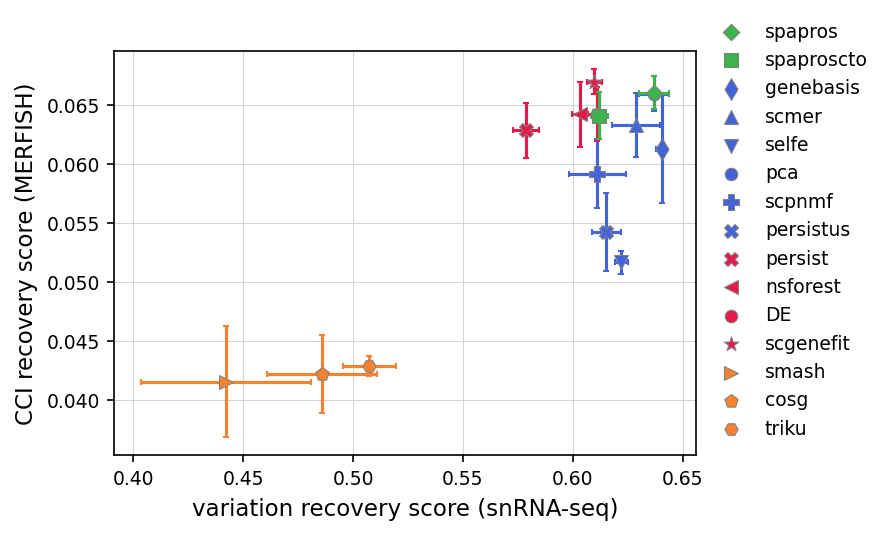

In [22]:
m = "sn"
n = 150
# 'CCI_n_interactions', 'CCI_mean_score', 'CCI_max_score'
metric_pairs = [
    ["var score", "CCI_n_interactions"],
]

S = 45
marker_to_size = {
    'D' : S * 0.7, # Diamond
    's' : S * 0.9, # Square
    '^' : S, # Triangle up
    'v' : S, # Triangle down
    '<' : S, # Triangle left
    '>' : S, # Triangle right
    'd' : S * 1.2, # Thin diamond
    'p' : S, # Pentagon
    '*' : S * 1.2, # Star
    'H' : S * 0.9, # Hexagon
    'P' : S * 1.4, # Plus
    'X' : S, # Cross
    'o' : S*0.8, # Circle
}

for (m1,m2) in metric_pairs:
    #print(f"########## selection on {m}, {n} selected genes ##########")
    
    fig = plt.figure(figsize=(5,3.5))#(7,5))
    
    # Subset to number of genes and modality
    df_ = df.loc[(df["n"]==n) & (df["modality"]==m)].copy()
    print("Correlation all points: ")
    print(df_[f"(sn) {m1}"].corr(df_[f"(sp) {m2}"]))
    #print(np.corrcoef(df_[f"(sn) {m1}"], df_[f"(sp) {m2}"])[0,1])
    
    df_ = get_plot_df(df_, f"(sn) {m1}", f"(sp) {m2}")
    # Get correlation
    print("Correlation of means: ")
    print(df_["x_mean"].corr(df_["y_mean"]))
    corr = df_["x_mean"].corr(df_["y_mean"])
    #print(np.corrcoef(df_["x_mean"], df_["y_mean"])[0,1])
    
    
    for method in df["method"].unique()[::-1]:
        #df_tmp = df_.loc[(df_["method"]==method)]
        #plt.scatter(df_tmp[f"(sn) {m1}"], df_tmp[f"(sp) {m2}"], color=colors[method], marker=markers[method], label=method, s=15)#30)
        row = df_.loc[method]
        plt.errorbar(row['x_mean'], row['y_mean'], xerr=row['x_std'], yerr=row['y_std'], color=colors[method], capsize=1.5, zorder=2)
        plt.scatter(
            df_.loc[method,f"x_mean"], df_.loc[method,f"y_mean"], color=colors[method], 
            marker=markers[method], label=method, s=marker_to_size[markers[method]],#45, 
            linewidths=0.5, edgecolors="gray", zorder=3
        )

    plt.xlabel(metric_to_label[m1] + " (snRNA-seq)") #f"(sn) {m1}") 
    plt.ylabel(metric_to_label[m2] + " (MERFISH)") #f"(sp) {m2}") 

    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[labels.index(method)] for method in colors]
    labels = list(colors.keys())
    plt.legend(handles, labels,frameon=False, loc="lower left", bbox_to_anchor=(1,0))
    fig.savefig(f"figures/1_1_scatterplot_sn_vs_sp_{m1}_r{np.round(corr,2)}.pdf", bbox_inches = "tight", transparent=True)
    plt.grid(color='lightgray', linestyle='-', linewidth=0.5, zorder=1)
    plt.show()